<a href="https://colab.research.google.com/github/tsitsvero/rotor-gp/blob/main/code/fit_energies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [4]:
# edit from colab, add installation instructions here
# !which python
# !python --version

!pip install git+https://github.com/lab-cosmo/librascal gpytorch pytorch-lightning wandb git+https://github.com/chem-gp/fande xtb


  Cloning https://github.com/lab-cosmo/librascal to /tmp/pip-req-build-jxpsfx72
  Running command git clone --filter=blob:none --quiet https://github.com/lab-cosmo/librascal /tmp/pip-req-build-jxpsfx72
  Resolved https://github.com/lab-cosmo/librascal to commit 6c55e99720f9a181f1efc5c7cd4976c87809d79b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/chem-gp/fande to /tmp/pip-req-build-flta0_zf
  Running command git clone --filter=blob:none --quiet https://github.com/chem-gp/fande /tmp/pip-req-build-flta0_zf
  Resolved https://github.com/chem-gp/fande to commit a83429a4a25a343ac706c0a013cbe824fa336442
  Preparing metadata (setup.py) ... done


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preparing model

In [15]:
import os
DATA_DIR = os.path.expanduser("~/repos/data/")
# DATA_DIR = "/data1/simulations/datasets/rotors/high_temp_ML_training_data/"
FANDE_DIR = os.path.expanduser("~/repos/")
RESULTS_DIR = os.path.expanduser("~/repos/data/results")
os.makedirs(RESULTS_DIR, exist_ok=True)

# DATA_DIR = os.path.expanduser("/content/drive/MyDrive/data/")
# # FANDE_DIR = os.path.expanduser("~/")
# RESULTS_DIR = os.path.expanduser("~/results")
# os.makedirs(RESULTS_DIR, exist_ok=True)

ENERGY_MODEL = 'variational_inducing_points' #'variational_inducing_points', 'exact'
ENERGY_LR = 0.01
ENERGY_NUM_STEPS = 5

FORCES_MODEL = 'variational_inducing_points' #'variational_inducing_points', 'exact'
NUM_FORCE_SAMPLES = 10
FORCES_LR = 0.01
FORCES_NUM_STEPS = 5

# Fit energies and forces (full cycle)

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import torch
sys.path.append(FANDE_DIR + "fande/")

In [3]:
%%time
from ase import io


traj_295 = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_295_295K/md_trajectory.traj", index=":")
# traj_355 = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_355_355K/md_trajectory.traj", index=":")
traj_295_2000K = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_295_2000K/md_trajectory.traj", index=":")
# traj_355_2000K = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_355_2000K/md_trajectory.traj", index=":")
# traj_295_2000K_forced = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_295_2000K_0075force/md_trajectory.traj", index=":")
# traj_355_2000K_forced = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_355_2000K_0075force/md_trajectory.traj", index=":")


CPU times: user 18 s, sys: 1.38 s, total: 19.4 s
Wall time: 19.4 s


In [4]:
trajectory_forces = traj_295_2000K[0:5000:5]
trajectory_forces = trajectory_forces[::20].copy()

# trajectory_energy = traj_295[0:5000] + traj_355[0:5000] + traj_295_2000K[0:5000] + traj_355_2000K[0:5000] + traj_295_2000K_forced[0:5000] + traj_355_2000K_forced[0:5000]
# trajectory_energy = traj_295 + traj_295_2000K + traj
trajectory_energy = traj_295[0:5000:10] +  traj_295_2000K[0:5000:10]
trajectory_energy = trajectory_energy[::20].copy()

print(len(trajectory_forces), len(trajectory_energy))

50 50


In [5]:
from fande.data import FandeDataModule
from fande.utils.find_atomic_groups import find_atomic_groups


soap_params = dict(soap_type="PowerSpectrum",
        interaction_cutoff=4.0,
        max_radial=4,
        max_angular=4,
        gaussian_sigma_constant=0.3,
        gaussian_sigma_type="Constant",
        cutoff_function_type="RadialScaling",
        cutoff_smooth_width=0.1, # 0.1 is way better than 0.5
        cutoff_function_parameters=
                dict(
                        rate=1,
                        scale=3.5,
                        exponent=4
                        ),
        radial_basis="GTO",
        normalize=True, # setting False makes model untrainable
        #   optimization=
        #         dict(
        #                 Spline=dict(
        #                    accuracy=1.0e-05
        #                 )
        #             ),
        compute_gradients=True, # for energies gradients are ignored
        expansion_by_species_method='structure wise'
        )
##FOR NOW USE THE SAME SOAP PARAMETERS FOR ENERGY AND FORCES! (that makes sense if you're modeling the MD)

sample_snapshot = trajectory_forces[0].copy()
fdm = FandeDataModule()
atomic_groups = find_atomic_groups(sample_snapshot)
train_centers_positions = sum(atomic_groups, []) #list(range(len(atoms)))
train_derivatives_positions = sum(atomic_groups, [])#list(range(len(atoms)))
fdm.atomic_groups_sample_snapshot = sample_snapshot.copy()
fdm.atomic_groups = atomic_groups

total_forces_samples_per_group = [NUM_FORCE_SAMPLES] * len(atomic_groups)
high_forces_samples_per_group = [0] * len(atomic_groups)

fande.models module imported...
Icecream logger is not available
Total number of found groups: 14
Checking if all atoms are covered:  True


In [6]:
dataloader_energy, dataloaders_forces = fdm.dataloaders_from_trajectory(
                                                                trajectory_energy,
                                                                trajectory_forces,
                                                                # energies = None,
                                                                # forces = None,
                                                                atomic_groups = atomic_groups,
                                                                centers_positions = train_centers_positions,
                                                                derivatives_positions = train_derivatives_positions,
                                                                energy_soap_hypers = soap_params,
                                                                forces_soap_hypers = soap_params,
                                                                total_forces_samples_per_group = total_forces_samples_per_group,
                                                                high_force_samples_per_group = high_forces_samples_per_group,
                                                                )

Total length of traj is 50
Total number of batches 50
Calculating invariants on trajectory with librascal...


100%|██████████| 50/50 [00:01<00:00, 37.81it/s]


invariants for energy fitting calculated


100%|██████████| 50/50 [00:41<00:00,  1.19it/s]


invariants for forces fitting calculated
torch.Size([50, 1200])
torch.Size([50])
Dataloader for group 0 created
Number of samples in dataloader: 10
Dataloader for group 1 created
Number of samples in dataloader: 10
Dataloader for group 2 created
Number of samples in dataloader: 10
Dataloader for group 3 created
Number of samples in dataloader: 10
Dataloader for group 4 created
Number of samples in dataloader: 10
Dataloader for group 5 created
Number of samples in dataloader: 10
Dataloader for group 6 created
Number of samples in dataloader: 10
Dataloader for group 7 created
Number of samples in dataloader: 10
Dataloader for group 8 created
Number of samples in dataloader: 10
Dataloader for group 9 created
Number of samples in dataloader: 10
Dataloader for group 10 created
Number of samples in dataloader: 10
Dataloader for group 11 created
Number of samples in dataloader: 10
Dataloader for group 12 created
Number of samples in dataloader: 10
Dataloader for group 13 created
Number of sam

In [16]:
# Making energy model

from fande.models import EnergyModel

hparams = {
        'dtype' : 'float32',
        # 'device' : 'gpu',
        'device' : 'cpu',
        'energy_model_hparams' : {
                'model_type' : ENERGY_MODEL,#'variational_inducing_points', 'exact'
                'num_inducing_points' : 10,
                'num_epochs' : ENERGY_NUM_STEPS,
                'learning_rate' : ENERGY_LR,
        }
        }

Energy_model = EnergyModel(
        dataloader_energy,
        hparams=hparams)

Energy_model.fit()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name       | Type                    | Params
-------------------------------------------------------
0 | likelihood | GaussianLikelihood      | 1     
1 | model      | SVGPModel               | 13.3 K
2 | mll        | PredictiveLogLikelihood | 13.3 K
-------------------------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Training with inducing points:  torch.Size([10, 1200])
Training energy model


/home/mm/miniforge3/envs/test_env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=1000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 41.71it/s, v_num=192, loss=1.220]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 31.65it/s, v_num=192, loss=1.220]


: 

In [14]:
%%time
# # Fitting forces

from fande.models import ModelForces, GroupModelForces


n_steps_list = [FORCES_NUM_STEPS] * len(atomic_groups)
lr_list = [FORCES_LR] * len(atomic_groups)

models_hparams = []
for i in range(len(atomic_groups)):
        model_hparams = {
        'atomic_group' : atomic_groups[i],
        'dtype' : hparams['dtype'],
        'device' : hparams['device'],
        'num_epochs' : n_steps_list[i],
        'learning_rate' : lr_list[i],
        'soap_dim' : dataloaders_forces[i].dataset[0][0].shape[-1],
        'soap_params' : soap_params,
        'forces_model_hparams' : {
                'model_type' : FORCES_MODEL,#'variational_inducing_points', 'exact'
                'num_inducing_points' : 10,
        }
        }
        
        models_hparams.append(model_hparams)

hparams['per_model_hparams'] = models_hparams # access per_model_hparams by model.model_id
gpu_id = 0


models_forces = []
for i in range(len(atomic_groups)):
        model = ModelForces(
        train_x = dataloaders_forces[i].dataset[:][0],
        train_y = dataloaders_forces[i].dataset[:][1],
        atomic_group = atomic_groups[i],
        hparams = hparams,
        id=i)
        models_forces.append(model)

AG_force_model = GroupModelForces(
        models= models_forces,
        train_data_loaders = dataloaders_forces,
        hparams=hparams,
        gpu_id=gpu_id)

AG_force_model.fit()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores



ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU availabl

Training force model 0 (Total 14 models)
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 77.34it/s, v_num=178, loss=2.810] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 48.32it/s, v_num=178, loss=2.810]



  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModel               | 1.2 K 
2 | mll        | ExactMarginalLogLikelihood | 1.2 K 
----------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Training force model 1 (Total 14 models)
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 72.82it/s, v_num=179, loss=1.610] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 46.70it/s, v_num=179, loss=1.610]



  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModel               | 1.2 K 
2 | mll        | ExactMarginalLogLikelihood | 1.2 K 
----------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Training force model 2 (Total 14 models)
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 76.79it/s, v_num=180, loss=4.050] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 48.67it/s, v_num=180, loss=4.050]



  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModel               | 1.2 K 
2 | mll        | ExactMarginalLogLikelihood | 1.2 K 
----------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Training force model 3 (Total 14 models)
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 75.35it/s, v_num=181, loss=1.430] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 50.40it/s, v_num=181, loss=1.430]



  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModel               | 1.2 K 
2 | mll        | ExactMarginalLogLikelihood | 1.2 K 
----------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Training force model 4 (Total 14 models)
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 79.50it/s, v_num=182, loss=4.550] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 56.78it/s, v_num=182, loss=4.550]



  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModel               | 1.2 K 
2 | mll        | ExactMarginalLogLikelihood | 1.2 K 
----------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Training force model 5 (Total 14 models)
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 81.33it/s, v_num=183, loss=1.760] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 52.72it/s, v_num=183, loss=1.760]



  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModel               | 1.2 K 
2 | mll        | ExactMarginalLogLikelihood | 1.2 K 
----------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Training force model 6 (Total 14 models)
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 76.03it/s, v_num=184, loss=3.860] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 51.44it/s, v_num=184, loss=3.860]



  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModel               | 1.2 K 
2 | mll        | ExactMarginalLogLikelihood | 1.2 K 
----------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Training force model 7 (Total 14 models)
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 87.80it/s, v_num=185, loss=1.490] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 58.67it/s, v_num=185, loss=1.490]



  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModel               | 1.2 K 
2 | mll        | ExactMarginalLogLikelihood | 1.2 K 
----------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Training force model 8 (Total 14 models)
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 81.55it/s, v_num=186, loss=4.570] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 54.28it/s, v_num=186, loss=4.570]



  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModel               | 1.2 K 
2 | mll        | ExactMarginalLogLikelihood | 1.2 K 
----------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Training force model 9 (Total 14 models)
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 81.50it/s, v_num=187, loss=1.730] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 55.57it/s, v_num=187, loss=1.730]



  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModel               | 1.2 K 
2 | mll        | ExactMarginalLogLikelihood | 1.2 K 
----------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Training force model 10 (Total 14 models)
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 77.57it/s, v_num=188, loss=3.170] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 55.98it/s, v_num=188, loss=3.170]



  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModel               | 1.2 K 
2 | mll        | ExactMarginalLogLikelihood | 1.2 K 
----------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Training force model 11 (Total 14 models)
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 72.68it/s, v_num=189, loss=5.560] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 46.98it/s, v_num=189, loss=5.560]



  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModel               | 1.2 K 
2 | mll        | ExactMarginalLogLikelihood | 1.2 K 
----------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Training force model 12 (Total 14 models)
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 79.15it/s, v_num=190, loss=3.000] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 57.17it/s, v_num=190, loss=3.000]



  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModel               | 1.2 K 
2 | mll        | ExactMarginalLogLikelihood | 1.2 K 
----------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Training force model 13 (Total 14 models)
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 82.24it/s, v_num=191, loss=2.600] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 54.53it/s, v_num=191, loss=2.600]
CPU times: user 26.4 s, sys: 689 ms, total: 27 s
Wall time: 3.73 s


In [9]:
from fande.predict import FandePredictor
from fande.ase import FandeCalc

# Energy_model = None
# AG_force_model = None
predictor = FandePredictor(
        fdm,
        AG_force_model,
        Energy_model,
        hparams,
        soap_params
        )

fande_calc = FandeCalc(predictor)

from datetime import datetime
now_str = str( datetime.now() )
device = torch.device('cpu')
fande_calc.predictor.move_models_to_device(device)
fande_calc.save_predictor(RESULTS_DIR + "/fande_predictor_" + now_str + ".pth")

Saving predictor requires humongous amount of memory! Spare some dozens of GBs!


In [10]:

# from fande.predict import FandePredictor
# from fande.ase import FandeCalc
# # load the predictor:
# # predictor_loaded = torch.load(RESULTS_DIR + "/fande_predictor.pth")
# predictor_loaded = torch.load("/root/results/fande_predictor_2023-12-28 17:39:36.114779.pth")
# fande_calc_loaded = FandeCalc(predictor_loaded)
# device = torch.device('cpu')
# fande_calc_loaded.predictor.move_models_to_device(device)

In [11]:
# device = torch.device('cuda:0') # always specify the gpu id!
device = torch.device('cpu')
fande_calc.predictor.move_models_to_device(device)

In [12]:
from ase import io
from tqdm import tqdm
test_traj = io.read(DATA_DIR + "/results_triasine_ML_2000/struct_295_295K/md_trajectory.traj", index="1235:1240")
test_traj = test_traj.copy()

real_energies = [s.get_potential_energy() for s in test_traj]
predicted_energies = []
for i in tqdm(range(len(test_traj))):
        test_traj[i].calc = fande_calc
        # predicted_energies.append( test_traj[i].get_potential_energy() )
        # print(test_traj[i].get_potential_energy() )
        print(test_traj[i].get_forces())
        print(test_traj[i].calc.get_forces_variance(test_traj[i]))
        print(test_traj[i].get_potential_energy() )
        # test_traj[i].get_forces()

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:01<00:07,  1.86s/it]

Time for invariants (call from forces):  1748.8195896148682
Predicting forces...
Energy model summary: 
Time invariants:  0.08106231689453125
Time prediction:  3.6923885345458984
Time moving on device:  0.4200935363769531
Time total:  4.734277725219727
[[ 0.10819796  0.10962636  0.10826141]
 [ 0.09433101  0.09566918  0.08296771]
 [ 0.09965261  0.09209567  0.09432316]
 ...
 [-0.06035503 -0.0277839  -0.04957563]
 [-0.01583641 -0.06039791 -0.06497205]
 [-0.05355797 -0.06072663 -0.03589166]]
[[1.74661863 1.7530216  1.73410857]
 [1.726982   1.73406446 1.68312037]
 [1.68957639 1.7233988  1.73530483]
 ...
 [1.44453752 1.44701123 1.43139076]
 [1.41232693 1.43146408 1.42491603]
 [1.45438218 1.40958178 1.44851327]]
[-3101.3271]


 40%|████      | 2/5 [00:02<00:03,  1.32s/it]

Time for invariants (call from forces):  871.1364269256592
Predicting forces...
Energy model summary: 
Time invariants:  0.09679794311523438
Time prediction:  3.0829906463623047
Time moving on device:  0.5052089691162109
Time total:  4.584312438964844
[[ 0.10818586  0.109711    0.10819017]
 [ 0.09450382  0.09345026  0.08306976]
 [ 0.09960146  0.09182519  0.0940918 ]
 ...
 [-0.06149533 -0.02869332 -0.05182519]
 [-0.0160897  -0.05891231 -0.06539716]
 [-0.05290276 -0.06079415 -0.03599602]]
[[1.74642062 1.7533561  1.73351705]
 [1.72901642 1.72419679 1.68337321]
 [1.68943667 1.72060144 1.73393321]
 ...
 [1.44069839 1.44840062 1.43329918]
 [1.41263437 1.43033242 1.42550647]
 [1.45232606 1.40948129 1.44851756]]
[-3101.3274]


 60%|██████    | 3/5 [00:03<00:02,  1.14s/it]

Time for invariants (call from forces):  851.2234687805176
Predicting forces...
Energy model summary: 
Time invariants:  0.0972747802734375
Time prediction:  2.547740936279297
Time moving on device:  0.46944618225097656
Time total:  3.792285919189453
[[ 0.10815792  0.10974915  0.10814682]
 [ 0.09469539  0.08996242  0.08765085]
 [ 0.09952424  0.09088102  0.09367089]
 ...
 [-0.0617011  -0.02953531 -0.05400803]
 [-0.01612046 -0.05503085 -0.06291905]
 [-0.05222102 -0.06086481 -0.03618202]]
[[1.74616635 1.75341761 1.73306775]
 [1.73130667 1.70449936 1.70961797]
 [1.68917155 1.71236384 1.73143709]
 ...
 [1.43416309 1.45192516 1.43624711]
 [1.41356874 1.42995715 1.42513609]
 [1.45004416 1.40936971 1.44860291]]
[-3101.3274]


 80%|████████  | 4/5 [00:04<00:01,  1.08s/it]

Time for invariants (call from forces):  926.490068435669
Predicting forces...
Energy model summary: 
Time invariants:  0.07987022399902344
Time prediction:  1.8210411071777344
Time moving on device:  0.41747093200683594
Time total:  2.8371810913085938
[[ 0.10810649  0.10973056  0.10814586]
 [ 0.0946143   0.08902908  0.08915067]
 [ 0.0994604   0.0893055   0.09318847]
 ...
 [-0.0614021  -0.02965637 -0.05473122]
 [-0.01628085 -0.05011908 -0.06104598]
 [-0.05159225 -0.06091562 -0.03638389]]
[[1.7458092  1.75318182 1.73283041]
 [1.73083115 1.69935679 1.71707714]
 [1.68896139 1.70016515 1.72847664]
 ...
 [1.43025422 1.45591772 1.43850064]
 [1.41463792 1.43017423 1.42482436]
 [1.44787455 1.40921211 1.44874203]]
[-3101.3274]


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]

Time for invariants (call from forces):  795.2520847320557
Predicting forces...
Energy model summary: 
Time invariants:  0.09799003601074219
Time prediction:  2.5703907012939453
Time moving on device:  0.5464553833007812
Time total:  3.9234161376953125
[[ 0.10803384  0.10966156  0.10818807]
 [ 0.09465671  0.08897699  0.08985084]
 [ 0.09947284  0.08766128  0.09282644]
 ...
 [-0.06132372 -0.02909834 -0.05322602]
 [-0.01636358 -0.04544666 -0.05930306]
 [-0.05106474 -0.06094793 -0.03659046]]
[[1.74535966 1.75269377 1.73281956]
 [1.73140252 1.69947171 1.72038651]
 [1.68912828 1.68867552 1.72611964]
 ...
 [1.4302181  1.45864534 1.43890405]
 [1.41553259 1.43067551 1.4246037 ]
 [1.44606996 1.4090929  1.44895434]]
[-3101.3274]


In [ ]:
import matplotlib.pyplot as plt

plt.plot(real_energies, label="real")
plt.plot(predicted_energies, label="predicted")
plt.legend()
plt.show()

## Testing area

In [ ]:
from ase import io
test_traj = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_295_295K/md_trajectory.traj", index="1000:1100")
# test_traj = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_295_2000K_0075force/md_trajectory.traj", index="-100:")
# test_traj = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/295_0.075_same_+/md_trajectory.traj", index="100:150")

# atoms.set_calculator(fande_calc_loaded)

In [ ]:
%%capture c
from tqdm import tqdm

energies_true = []
energies_pred = []

for i in tqdm(range(len(test_traj))):
        atoms = test_traj[i].copy()
        atoms.calc = fande_calc
        energies_pred.append(atoms.get_potential_energy())
        energies_true.append(test_traj[i].get_potential_energy())


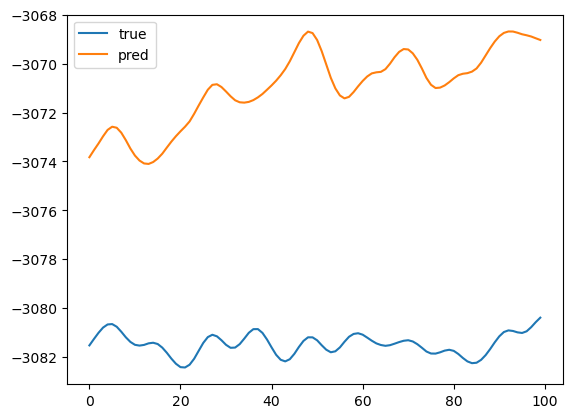

In [ ]:
import matplotlib.pyplot as plt
plt.plot(energies_true, label="true")
plt.plot(energies_pred, label="pred")
plt.legend()
plt.show()

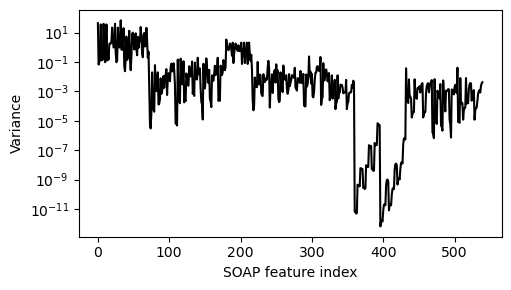

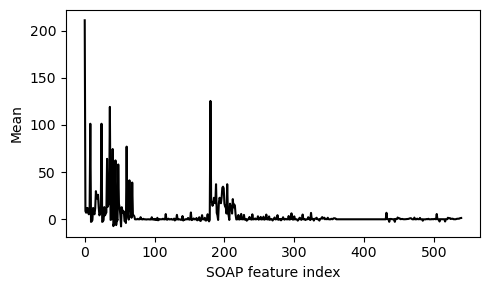

In [ ]:
fande_calc.predictor.energy_model.model.model.variational_strategy.inducing_points

# import matplotlib.pyplot as plt

train_x = fande_calc.predictor.energy_model.model.train_x[:].cpu().detach().numpy()
mean_train_x = train_x.mean(axis=0)

train_x_no_mean = train_x - mean_train_x
train_x_variance = train_x_no_mean.var(axis=0)

plt.figure(figsize=(5,3))
plt.plot(train_x_variance, color="black")
plt.xlabel("SOAP feature index")
plt.ylabel("Variance")
plt.tight_layout()
plt.yscale('log')
# plt.xlim(210,215)
# plt.ylim(0,2.0)
# plt.savefig("variance.pdf")
plt.show()


# plt.figure(figsize=(5,3))
# plt.hist(train_x_variance, bins=100, color="black")
# plt.xlabel("Variance")
# plt.ylabel("Count")
# plt.tight_layout()
# plt.yscale('log')
# # plt.savefig("variance_hist.pdf")
# plt.show()

plt.figure(figsize=(5,3))
plt.plot(mean_train_x, color="black")
plt.xlabel("SOAP feature index")
plt.ylabel("Mean")
plt.tight_layout()
# plt.yscale('log')
# plt.savefig("mean.pdf")
plt.show()

# for i in range(0,1000):
#         # plt.plot(fande_calc.predictor.energy_model.model.model.variational_strategy.inducing_points[i].cpu().detach().numpy().flatten())
#         plt.plot(train_x[2*i].flatten() - mean_train_x.flatten())
# # plt.hist(fande_calc.predictor.energy_model.model.train_x.cpu().detach().numpy().flatten(), bins=100)
# # plt.xlim(50, 60)
# plt.show()

In [ ]:
from ase.build import molecule
from ase.build import fcc111
from xtb.ase.calculator import XTB
from ase import io


# slab = fcc111('Cu', size=(2,2,3), vacuum=10.0)
atoms = molecule('H2O')
# atoms.set_cell([10, 10, 10])
# atoms.set_pbc(True)
# io.write("coord.tmol", atoms, format="turbomole")
# io.write("poscar", atoms, format="vasp")
# io.write("test.cif", atoms, format="cif")
# io.write("test.xyz", atoms, format="extxyz")
# atoms = slab.copy()
# atoms.calc = XTB(method="GFN2-xTB")
atoms.calc = XTB(method="gfnff")
atoms.get_potential_energy()

atoms.get_forces()


          ==================== Thresholds ====================
          CN  :   150.00000
          rep :   500.00000
          disp:  2500.00000
          HB1 :   250.00000
          HB2 :   450.00000

          Pauling EN used:
          Z : 1  EN :  2.20
          Z : 8  EN :  3.44
          electric field strengths (au): 0.000

           ------------------------------------------------- 
          |           Force Field Initialization            |
           ------------------------------------------------- 

          distances ...
          ----------------------------------------
          generating topology and atomic info file ...
          pair mat ...
          computing topology distances matrix with Floyd-Warshall algo ...
          making topology EEQ charges ...
          #fragments for EEQ constrain: 1
          fragment charges from <charges> :  0.000
          ----------------------------------------
          generating topology and atomic info file ...
        

array([[-0.00000000e+00, -1.78406134e-15, -1.27379911e-01],
       [-0.00000000e+00,  1.97684139e-01,  6.36899553e-02],
       [-0.00000000e+00, -1.97684139e-01,  6.36899553e-02]])

: 